# Exploratory Data Analysis of numerical FWI-Forecast

## Introduction
The Fire Weather Index (FWI) is a meteorologically based index used worldwide to estimate fire danger. It consists of different components that account for the effects of fuel moisture and wind on fire behaviour and spread. The higher the FWI, the more favorable the meteorological conditions to trigger a wildfire. This indicator can help shape long-term tourist strategy and to plan future investments under a changing climate.

The [`esowc/wildfire-forecasting`](https://github.com/esowc/wildfire-forecasting) project intends to reproduce the Fire Forecasting capabilities of GEFF using Deep Learning and develop further improvements in accuracy, geography and time scale through inclusion of additional variables or optimisation of model architecture & hyperparameters. 

In this notebook we explore the numerically predicted FWI-Forecast which is produced from forecasted weather data. These numerical predictions take as input weather forcings for 10 days and the model produces FWI forecast for 10 days.
```
                                            ___________________________
Weather Forcings (t, t+1, t+2, ..., t+9) -> | numerical calculations  |  -> FWI-Forecast (t, t+1, t+2, ..., t+9)
                                            ---------------------------
```

To run this notebook, make sure you have the `wildfire-dl` `conda` environment activated. Instructions for setting up the environment are available in the project [`README`](https://github.com/esowc/wildfire-forecasting/blob/master/README.md).

## Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [1]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

## Getting the data

We first obtain a sample dataset (~`1.5GB` in size). This data is stored on a publicly accessible GCP bucket at `gs://deepfwi-mini-sample` and is downloaded into `data/mini_sample/`

Navigate to the root of the repo

In [2]:
os.chdir('../..')

Getting the data from GCP bucket,

In [3]:
# Uncomment the code below to download data from GCP
# !mkdir data/mini_sample -p
# !gsutil -q cp -r 'gs://deepfwi-mini-sample/*' data/mini_sample

Sample of files we just fetched,

In [4]:
files = glob('data/mini_sample/fwi-forecast/*')
files

['data/mini_sample/fwi-forecast/ECMWF_FWI_20191204_1200_hr_fwi.nc']

## Preprocessing

Each file contains the actual observation along with 9 day forecast. We are exploring only the first day.

In [5]:
data = xr.open_dataset(files[0])
data = data.isel(time=slice(0,1))

Taking a look.

In [6]:
print(data)

<xarray.Dataset>
Dimensions:  (lat: 2560, lon: 5120, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2019-12-04
  * lon      (lon) float32 0.0 0.0703125 0.140625 ... 359.85938 359.9297
  * lat      (lat) float32 89.94619 89.87648 89.80636 ... -89.87648 -89.94619
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Tue Jun 09 17:36:36 2020: cdo --silent -select,name=fw...
    Reference date:    20191204
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...


**Pixel resolution**: *2560x5120*<br>
**Longitude resolution**: 0.0703125<br>
**Latitude resolution**: 0.06971<br>

## Visualisation

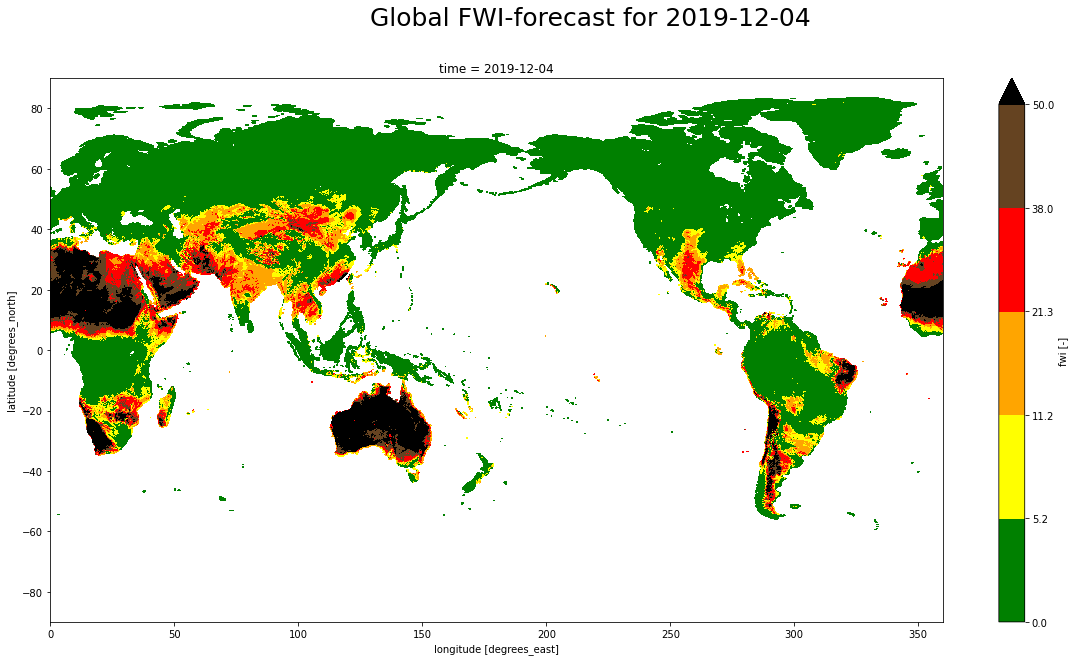

In [7]:
plt.figure(figsize = (20,10)).suptitle(f"Global FWI-forecast for {str(data.fwi[0].time.values.astype('datetime64[D]'))}", fontsize=25)
data.fwi[0].plot(levels = [0.0, 5.2, 11.2, 21.3, 38.0, 50.0],
                 colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000", "#654321", "#000000"],
                 label = ['Very low', 'Low', 'Moderate', 'High', 'Very high', 'Extreme'])

## Data Statistics

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [8]:
np.isnan(data.fwi[0].values).any()

True

Printing general stats. During calculation, the NaN values are skipped using `skipna` parameter.

In [9]:
def stats(x):
    tmp = x.mean(skipna=True).values
    print('Mean'.ljust(10), tmp)
    print('MAD'.ljust(10), abs(x-tmp).mean(skipna=True).values)
    print('Variance'.ljust(10), x.var(skipna=True).values)
    print('Minimum'.ljust(10), x.min(skipna=True).values)
    print('Maximum'.ljust(10), x.max(skipna=True).values)

In [10]:
stats(data.fwi)

Mean       11.720076
MAD        15.621397
Variance   452.3061
Minimum    1.7634524e-09
Maximum    159.19333
